### Домашняя работа

**Задание простого уровня** Мы говорили, что метрики качества нужны, чтобы сравнивать различные модели между собой. В задаче полиномиальной регрессии реализуйте код для выбора лучшей степени полиному:

* возьмите все степени от 1 до 10 по порядку, без пропусков.
* найдите степень полинома, где будет лучший r2-score
* напишите код, который выводит самую подходящую степень полинома и соответствующий ей скор

Эта процедура называется Grid Search и помогает найти лучшие параметры для модели.

Обучите лучшую модель и сделайте predict

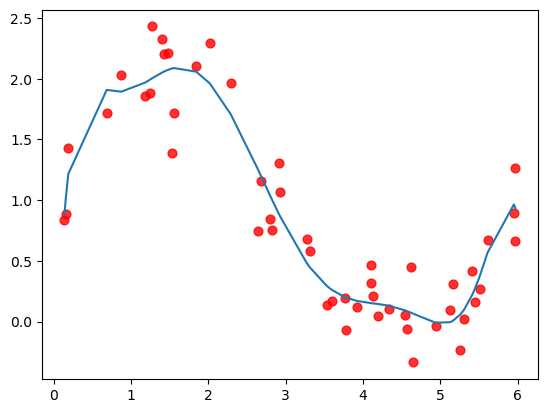

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv('../../../datasets/3.10_non_linear.csv')
x_train = df['x_train'].values
y_train = df['y_train'].values

def generate_degrees(source_data: np.ndarray, degree: int):
    """Generates a new feature matrix consisting of all polynomial combinations of the features with degree"""
    return PolynomialFeatures(degree).fit_transform(source_data.reshape(-1, 1))

def train_polynomial(Xtr, Ytr):
    """Generates data, trains the model, and plots the graph"""

    _deg = 0
    _score = 0
    #axs = plt.subplots(5, 2, figsize=(10, 20))[1]  # Create subplots for the unified plot

    for degree in range(1, 11):
        X = generate_degrees(Xtr, degree)
        model = LinearRegression().fit(X, Ytr)
        y_pred = model.predict(X)
        score = r2_score(Ytr, y_pred)
        #print(f"Degree of the polynomial {degree}, R2 score: {score:.3f}")

        if score > _score:
            _score = score
            _deg = degree
        # ax = axs[(degree-1)//2, (degree-1)%2]
        # ax.plot(x_train, y_pred, label=f'Degree {degree}')
        # ax.scatter(x_train, y_train, 40, 'g', 'o', alpha=0.8, label='data')
        # ax.legend()
    # plt.tight_layout()
    # plt.show()
    
    # plt.scatter(x_train, y_train, 40, 'g', 'o', alpha=0.5, label='data')
    # plt.legend()
    # plt.show()
    return _deg, _score

deg,_ = train_polynomial(x_train, y_train)

X = generate_degrees(x_train, deg)
model = LinearRegression().fit(X, y_train)
y_pred = model.predict(X)

plt.plot(x_train, y_pred)
plt.scatter(x_train, y_train, 40, 'r', 'o', alpha=0.8)
plt.show()

**Задание среднего уровня** Напишите класс для обучения модели, который содержит:

* функцию `.fit(X, y)` , которая принимает на вход массив фичей `X`, массив таргетов `y` и обучает коэффициенты регрессии. Код для обучения взять из первого урока модуля *Постановка ML задачи линейной регрессии*
* функцию `.predict(X)`, которая по массиву фичей `X` возвращает массив предсказаний `y`

Нужно использовать код для аналитически вычисляемых коэффициентов.

Это задание позволит понять, как работает линейная регрессия "внутри" библиотечной реализации.

$$
\overline{w} = \left(X^TX\right)^{-1}X^TY
$$

In [51]:
import numpy as np
from numpy.linalg import inv

class CustomLinearReg:
    def __init__(self):
        self.w = None

    def __transformArray(self, Array: list) -> np.array:
        #X = np.reshape(X, (-1,1))
        #X = np.insert(X, 0,1, axis=-1)
        return np.c_[np.ones(Array.shape[0]), Array] # 1xN matrix concat Array || Stack 1-D arrays as columns into a 2-D array.

    def fit(self, X: list, y: list) -> CustomLinearReg:
        X = self.__transformArray(X)
        self.w = inv(X.T.dot(X)).dot(X.T).dot(y)
        return self

    def predict(self, X: list) -> np.array:
        if self.w is None:
            print(Exception("Fit the model before predicting!"))
            return self
        X = self.__transformArray(X)
        return X.dot(self.w)

In [68]:
sthX = np.linspace(-10, 10, 80)
Y = lambda X: 5*X**3 - X**2 + X + 3
model = CustomLinearReg().fit(sthX, Y(sthX))
y_pred = model.predict(sthX)
print(model.w)

[-31.17721519 308.53084442]


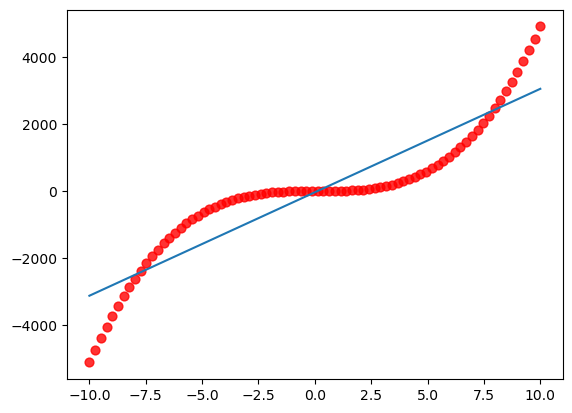

In [69]:
plt.scatter(sthX, Y(sthX), 40, 'r', 'o', alpha=0.8, label='data')
plt.plot(sthX, y_pred, label='predict')
plt.show()

**Задание высокого уровня**

1. разделите датасет с домами Бостона из Урока 2 (таргет и фичи) на две части: в одной части 80% датасета (назовём train) в другой 20% (назовём valid) с помощью функции `train_test_split` из библиотеки `sklearn`
1. обучите модель только на train датасете
1. постройте предсказания valid датасете
1. Посчитайте  `r2 score` на валидационном сете

После этого примените к обеим датасетам z-преобразование и повторите шаги 2-4. Как изменилась метрика r2?

Это задание поможет понять, как валидировать линейную регрессию (и другие модели) на отложенной выборке.

In [45]:
from sklearn.datasets import fetch_openml 
 
boston_dataset = fetch_openml(data_id=42165, as_frame=True) #ID Бостон

boston_dataset.data = boston_dataset.data.select_dtypes(exclude=['object']) #Исключить признаки с типом object

boston_dataset.data = boston_dataset.data.dropna() # Drop NAN
boston_dataset.target = boston_dataset.target[boston_dataset.data.index]

features = boston_dataset.data #Выделяем фичи
y = boston_dataset.target
print(features.shape, y.shape)

(1121, 37) (1121,)


In [50]:
#Разделить на 20\80
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(features, y, test_size=0.2, random_state=57)

# Обучить линеную модель
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, Y_train)

#Оценка R2
from sklearn.metrics import r2_score as r2
y_predict = model.predict(X_valid)

print('R2-score: %s' %r2(Y_valid, y_predict))

R2-score: 0.6864088966697196


In [51]:
#Z-SCALE
from sklearn.preprocessing import StandardScaler
zcale = StandardScaler().fit(X_train)
X_train_Z = zcale.transform(X_train)
X_valid_Z = zcale.transform(X_valid)

Y_train = Y_train.values.reshape(-1,1)
Y_valid = Y_valid.values.reshape(-1,1)

#Обучить модель
model_ = LinearRegression().fit(X_train_Z, Y_train)

#R2
Y_predict = model_.predict(X_valid_Z)
print('R2 with Z-Scale: %s' %r2(Y_valid, Y_predict))

R2 with Z-Scale: 0.6867494692245157


Применение ZScale позволяет улучшить результат по метрике R2Score. Необходимо проводить точную предобработку данных от содержимого задачи